In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler

# Variables from config file
import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/writeup/')
from util import load_data, TransferModel
from config import FILENAME, C_SINGLE, C_GRID, C_COMMON
# enable autoreload
%load_ext autoreload
%autoreload 2

2022-08-17 00:34:04.819961: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
columns = C_SINGLE + ['elevation', 'lat', 'lon']
df_train, df_test = load_data(columns + C_COMMON, FILENAME)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

def define_model(
    input_dim=20,
    n_units=512,
    activation='selu',#selu
    learning_rate=0.00001,
    loss='mse',
    batch_size=64
):
    inputs = Input(shape=(input_dim))
    x = Dense(units=n_units, activation=activation, kernel_regularizer=L2(l2=1e-3))(inputs)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=n_units, activation=activation, kernel_regularizer=L2(l2=1e-3))(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=n_units, activation=activation, kernel_regularizer=L2(l2=1e-3))(x)
    x = Dropout(rate=0.5)(x)# serves as regularization
    outputs = Dense(units=1, activation='softplus', kernel_regularizer=L2(l2=1e-3))(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
        loss=loss,
        metrics=[RootMeanSquaredError()]
    )
    return model, batch_size


In [8]:
# get the best hyperparameter for the base model
df_hyperparameter = pd.read_csv('nn_report_base_500_single.csv')
df_hyperparameter[df_hyperparameter['rmse'] == df_hyperparameter['rmse'].min()]

,Unnamed: 0,trial_id,rmse,mae,n_units,learning_rate,batch_size,loss,input_dim
27,0,27,4.029236,2.385619,708,0.000401,512,mae,19


In [18]:
t_model = TransferModel(define_model, columns)

params={
    'n_units': 708,
    'learning_rate': 0.000401,
    'input_dim': 19,
    'batch_size': 512,
    'loss': 'mse'
}
t_model.evaluate_base(df_train, df_test, params, save=True, filename='model_weights/base_model.h5')

{'rmse': 3.4064351397309025, 'mae': 2.029382539941294}

In [5]:
t_model = TransferModel(define_model, columns)
t_model.evaluate_by_station(df_train, df_test, skn=54, params={"batch_size":64})

2022-08-17 00:34:28.986668: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-17 00:34:28.988993: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-17 00:34:29.032554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-17 00:34:29.032598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-17 00:34:29.035113: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-17 00:34:29.035186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Epoch 1/1000


2022-08-17 00:34:30.569794: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


8/8 [==============================] - 1s 32ms/step - loss: 4.6560 - root_mean_squared_error: 2.0052 - val_loss: 2.2938 - val_root_mean_squared_error: 1.3305
Epoch 2/1000
8/8 [==============================] - 0s 9ms/step - loss: 1.9957 - root_mean_squared_error: 1.2109 - val_loss: 1.8724 - val_root_mean_squared_error: 1.1614
Epoch 3/1000
8/8 [==============================] - 0s 9ms/step - loss: 1.5800 - root_mean_squared_error: 1.0263 - val_loss: 0.9562 - val_root_mean_squared_error: 0.6580
Epoch 4/1000
8/8 [==============================] - 0s 9ms/step - loss: 1.3292 - root_mean_squared_error: 0.8974 - val_loss: 0.9664 - val_root_mean_squared_error: 0.6661
Epoch 5/1000
8/8 [==============================] - 0s 9ms/step - loss: 1.2847 - root_mean_squared_error: 0.8725 - val_loss: 0.9226 - val_root_mean_squared_error: 0.6330
Epoch 6/1000
8/8 [==============================] - 0s 9ms/step - loss: 1.0708 - root_mean_squared_error: 0.7406 - val_loss: 0.8808 - val_root_mean_squared_error:

{'rmse': 4.974773039792652, 'mae': 3.2583657202353837}

In [25]:
# model = create_model()

# skn = 54
# df_train_station = df_train[df_train['skn'] == skn]
# df_test_station = df_test[df_test['skn'] == skn]

# x_train, x_test = np.array(df_train_station[columns]), np.array(df_test_station[columns])
# y_train, y_test = np.array(df_train_station['data_in']), np.array(df_test_station['data_in'])

# scaler = MinMaxScaler()
# #XTRAIN = np.array(df_train[columns])

# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

# y_train = np.log(y_train + 1.)
# y_test = np.log(y_test + 1.)

# callbacks = [
#     EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
# ]
# history = model.fit(
#     x_train, y_train,
#     epochs=int(1e3),
#     validation_split=0.2,
#     callbacks=callbacks,
#     verbose=1
# )

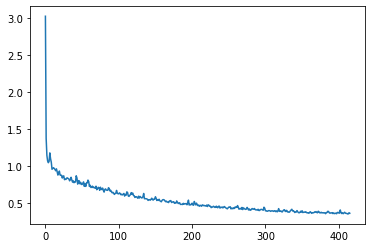

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [20]:
y_pred = model.predict(x_test)
y_pred = np.power(np.e, y_pred) + 1.
y_test_ = np.power(np.e, y_test) + 1.

mean_squared_error(y_test_, y_pred, squared=False)

4.942516484027011

In [237]:
# model.trainable = True
model.save('model_weights/ready_for_fine_tune.hdf5')

In [252]:
model = tf.keras.models.load_model('model_weights/ready_for_fine_tune.hdf5')
model.trainable = True

# first train with strict patience with validation set
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=2)
]
            
history = model.fit(
    x_train, y_train,
    epochs=int(1e3),
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/1000
16/16 [==============================] - 1s 16ms/step - loss: 0.3717 - root_mean_squared_error: 0.4614 - val_loss: 0.3675 - val_root_mean_squared_error: 0.4595
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3744 - root_mean_squared_error: 0.4673 - val_loss: 0.3626 - val_root_mean_squared_error: 0.4564
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3669 - root_mean_squared_error: 0.4615 - val_loss: 0.3967 - val_root_mean_squared_error: 0.4945
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3572 - root_mean_squared_error: 0.4531 - val_loss: 0.3774 - val_root_mean_squared_error: 0.4765
Epoch 5/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3657 - root_mean_squared_error: 0.4638 - val_loss: 0.3592 - val_root_mean_squared_error: 0.4587
Epoch 6/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3580 - root_mean_squared_error: 0.4576 - val_loss: 0.3507 - val

In [253]:
y_pred = model.predict(x_test)
y_pred = np.power(np.e, y_pred) + 1.
mean_squared_error(y_test_, y_pred, squared=False)

4.899945757642023

In [255]:
# now redo with the whole training data

model = tf.keras.models.load_model('model_weights/ready_for_fine_tune.hdf5')
model.trainable = True

# first train with strict patience with validation set
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

callbacks = [
    EarlyStopping(monitor='loss', min_delta=0, patience=1000, restore_best_weights=True),
    # ReduceLROnPlateau(monitor='loss', factor=0.9, patience=2)
]
            
model.fit(
    x_train, y_train,
    epochs=len(history.history['loss']),
    validation_split=0,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/77
20/20 [==============================] - 1s 3ms/step - loss: 0.3585 - root_mean_squared_error: 0.4480
Epoch 2/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3627 - root_mean_squared_error: 0.4557
Epoch 3/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3533 - root_mean_squared_error: 0.4482
Epoch 4/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3462 - root_mean_squared_error: 0.4428
Epoch 5/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3656 - root_mean_squared_error: 0.4664
Epoch 6/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3221 - root_mean_squared_error: 0.4199
Epoch 7/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3285 - root_mean_squared_error: 0.4293
Epoch 8/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3233 - root_mean_squared_error: 0.4257
Epoch 9/77
20/20 [==============================] - 0s 3ms/step - loss: 0.3435 - root_mean_squar

In [256]:
y_pred = model.predict(x_test)
y_pred = np.power(np.e, y_pred) + 1.
mean_squared_error(y_test_, y_pred, squared=False)

4.841681178097757